# Train with stable baselines 

In [1]:
import gym
import gym_defender

from stable_baselines.common.policies import FeedForwardPolicy as FFP_common
from stable_baselines.deepq.policies import FeedForwardPolicy as FFP_DQ

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import DQN

import numpy as np
from matplotlib.pyplot import plot

In [2]:
class MLP_PPO(FFP_common):
    def __init__(self, *args, **kwargs):
        super(MLP_PPO, self).__init__(*args, **kwargs,
                                           net_arch=[dict(pi=[300, 300], vf=[300, 300])],
                                           feature_extraction="mlp")
        
class MLP_DQN(FFP_DQ):
    def __init__(self, *args, **kwargs):
        super(MLP_DQN, self).__init__(*args, **kwargs,
                                           layers=[300, 300],
                                           layer_norm=False,
                                           feature_extraction="mlp")


In [5]:
class Defense:
    def __init__(self, method, K=5, P=0.95):
        self.method = method
        
        self.K = K
        self.state_size        = 2 * (self.K + 1)
        self.action_size       = 2
        self.reward            = []
        
        env_name = 'defender-' + str(K) + '-' + str(P) + '-v1'
        
        env = gym.make(env_name)
        self.envs = DummyVecEnv([lambda: env])
        
        if method=='PPO':
            self.model = PPO2(MLP_PPO, self.envs, verbose=0)
        elif method=='DQN':
            self.model = DQN(MLP_DQN, self.envs, verbose=0)
        else:
            raise Exception("Erreur ! Méthode: 'PPO' ou 'DQN'")
        print("Model Initialized !")
        
        
    def learn(self, timesteps=10000):
        self.model.learn(total_timesteps = timesteps)
        print("======\nLEARNING DONE\n======")

    def save(self, filename):
        self.model.save(filename)
        print("Model saved !\n Filename:", filename)

    def load(self, filename):
        if self.method=='PPO':
            self.model = PPO2.load(filename, policy=MLP_PPO)
        else:
            self.model = DQN.load(filename, policy=MLP_DQN)
        print("Model loaded !")
        
    
    
    def run(self, nb_episodes = 1000):
        self.nb_episodes = nb_episodes
        
        for index_episode in range(nb_episodes):
            state = self.envs.reset()
            state = np.reshape(np.array(state), [1, self.state_size])
            done = False
            steps = 0
            while not done:
                 action, _states = self.model.predict(state)
                 next_state, reward, done, _ = self.envs.step(action)
                 next_state = np.reshape(np.array(next_state), [1, self.state_size])
                 state = next_state
                 steps += 1
            if index_episode %100 == 0:
                print("Episode {}#; \t Nb of steps: {}; \t Reward: {}.".format(index_episode, steps + 1, reward))
            if index_episode > 0:
                self.reward += [((self.reward[-1] * len(self.reward)) + reward) / (len(self.reward) + 1)]
            else:
                self.reward += [reward]

LEARNING DONE
Episode 0#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 100#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 200#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 300#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 400#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 500#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 600#; 	 Nb of steps: 5; 	 Reward: [1.].
Episode 700#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 800#; 	 Nb of steps: 5; 	 Reward: [1.].
Episode 900#; 	 Nb of steps: 5; 	 Reward: [1.].
Episode 1000#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 1100#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 1200#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 1300#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 1400#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 1500#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 1600#; 	 Nb of steps: 4; 	 Reward: [1.].
Episode 1700#; 	 Nb of steps: 5; 	 Reward: [1.].
Episode 1800#; 	 Nb of steps: 6; 	 Reward: [1.].
Episode 1900#; 	 Nb of steps: 6; 	 Reward: [1.].


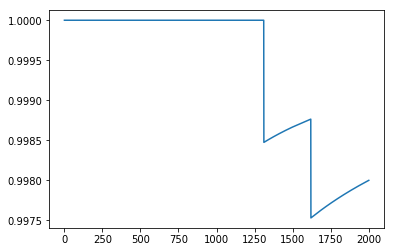

In [6]:
defense = Defense('DQN', K=5, P=0.95)
defense.learn(20000)
defense.run(2000)
plot(range(1, defense.nb_episodes+1), defense.reward)

In [7]:
defense.save('DQN_5_0.95_20k')